### This is a self-driving car project to detect vehicle on the road!

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *

In [2]:
cars_far = glob.glob('./vehicles/GTI_Far/*.png')
cars_middle = glob.glob('./vehicles/GTI_MiddleClose/*.png')
cars_left = glob.glob('./vehicles/GTI_Left/*.png')
cars_right = glob.glob('./vehicles/GTI_Right/*.png')
cars_extracted = glob.glob('./vehicles/KITTI_extracted/*.png')

In [3]:
notcars = glob.glob('./non-vehicles/Extras/*.png')
notcars += glob.glob('./non-vehicles/GTI/*.png')

In [4]:
cars=cars_far+cars_middle+cars_left+cars_right+cars_extracted

In [5]:
len(cars)

8792

In [6]:
len(notcars)

8968

### Firstly, we need to store all the image data into .p file so that we can get data more easily

I am planning to set 80% as the training data and 20% as the data set 

In [7]:
pickle_file = 'data.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'cars': cars,
                'notcars': notcars
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Saving data to pickle file...


In [8]:
datafile = 'data.p'
with open(datafile, mode='rb') as f:
    data = pickle.load(f)

Over here, split data into training test set and test data set

In [9]:
cars_data=data['cars']
notcars_data=data['notcars']
cars_train,cars_test=train_test_split(cars_data,test_size=0.2)
notcars_train,notcars_test=train_test_split(notcars_data,test_size=0.2)

We need to create a function used to get features from images

In [10]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Let's see a simple demo how to get Histogram of Oriented Gradients

In [11]:
%matplotlib inline
pix_per_cell=8
cell_per_block=2
orient=9
img=cars_train[0]
img=mpimg.imread(img)
demo_features=[]
hog_image_demo=[]
for channel in range(img.shape[2]):
    features,hog_image=get_hog_features(img[:,:,channel], orient, pix_per_cell,\
                                        cell_per_block, vis=True, feature_vec=True)
    demo_features.append(features)
    hog_image_demo.append(hog_image)

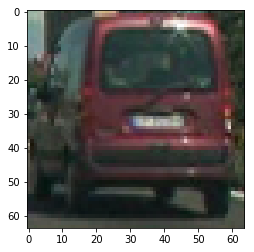

In [12]:
plt.imshow(img)

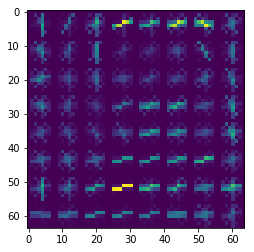

In [13]:
plt.imshow(hog_image_demo[0])

In [14]:
demo_features[0].shape

(1764,)

In [36]:
feature_training_cars=[]
for file in cars_train:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='HLS', spatial_size=(16,16),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_training_cars.append(img_features)

feature_testing_cars=[]
for file in cars_test:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='HLS', spatial_size=(16,16),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_testing_cars.append(img_features)

feature_training_notcars=[]
for file in notcars_train:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='HLS', spatial_size=(16,16),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_training_notcars.append(img_features)

feature_testing_notcars=[]
for file in notcars_test:
    img=mpimg.imread(file)
    img_features = single_img_features(img, color_space='HLS', spatial_size=(16,16),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_testing_notcars.append(img_features)


### Now features have been extracted, now we need to use SVM to explore data

In [37]:
# Create an array stack of feature vectors
X = np.vstack((feature_training_cars,feature_training_notcars)).astype(np.float64)  
y_train = np.hstack((np.ones(len(feature_training_cars)), np.zeros(len(feature_training_notcars))))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
X_train=scaled_X

In [38]:
X_train[0].shape

(6156,)

In [39]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("the time for fitting:{}".format(t2-t))

the time for fitting:18.064584016799927


In [40]:
X_test = np.vstack((feature_testing_cars,feature_testing_notcars)).astype(np.float64)  
y_testing = np.hstack((np.ones(len(feature_testing_cars)), np.zeros(len(feature_testing_notcars))))
X_test_scaler = StandardScaler().fit(X_test)
X_testing = X_test_scaler.transform(X_test)

In [41]:
X_testing[0].shape

(6156,)

Now we can use our classifier to test accuracy on our test data set

In [42]:
print('Test Accuracy of SVC = ', round(svc.score(X_testing, y_testing), 4))

Test Accuracy of SVC =  0.9901


## Then, we need to construct a function to search windows

In [43]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(16, 16), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [44]:
# Define a function to return HOG features and visualization
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [45]:
color_space = 'HLS'
spatial_size = (16,16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

In [92]:
#Got an idea from the forum and referenced some codes from there
def get_rectangle_cars(image):
    hot_windows = []
    all_windows = []
    
    X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
    #w0,w1,w2,w3 = 240,180,120,70
    #o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    XY_window = [(70,70),[120,120],[64,64]]
    XY_overlap = [(0.7,0.7),(0.7,0.7),(0.75,0.75)]
    #yi0,yi1,yi2,yi3 = 380,380,395,405                  
    Y_start_stop =[[400,655],[400,655],[400,655]]    
    
    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

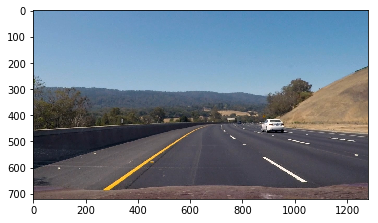

In [93]:
test_image=mpimg.imread("test_images/test3.jpg")
plt.imshow(test_image)

In [94]:
image_copy=np.copy(test_image)
hot_windows,all_windows=get_rectangle_cars(image_copy)

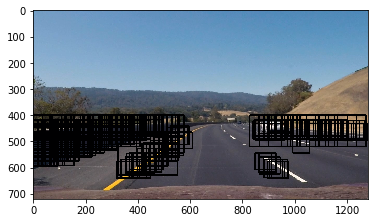

In [95]:
draw_image = np.copy(test_image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4) 
plt.imshow(window_img)

In [96]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

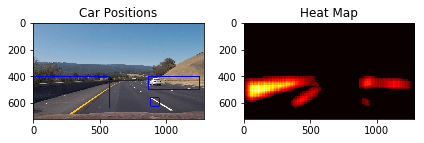

In [97]:
from scipy.ndimage.measurements import label
image = mpimg.imread('test_images/test3.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
box_list=hot_windows
heat = add_heat(heat,box_list)
#heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

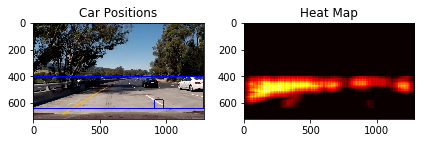

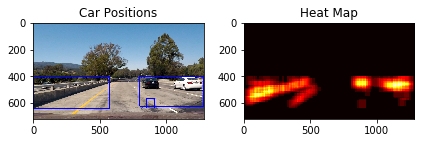

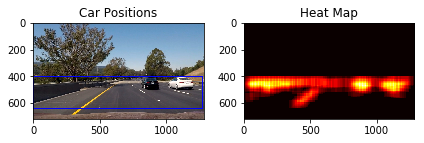

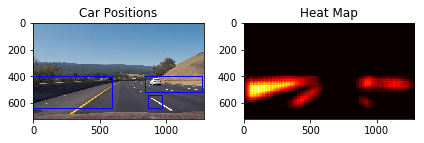

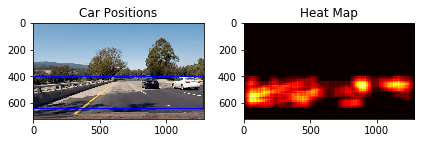

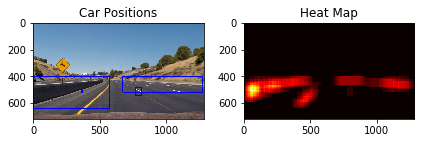

In [98]:
images=glob.glob("test_images/*.jpg")
for i in range(len(images)):
    image = mpimg.imread(images[i])
    hot_windows,all_windows=get_rectangle_cars(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list=hot_windows
    heat = add_heat(heat,box_list)
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [131]:
def process_image(image):
    hot_windows,all_windows=get_rectangle_cars(image)
    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4) 
    return window_img

In [132]:
from moviepy.editor import VideoFileClip
video_output = 'result_test.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_test.mp4
[MoviePy] Writing video result_test.mp4


 97%|█████████▋| 38/39 [01:27<00:02,  2.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test.mp4 

